## 2D Case - Figures 13

Convergence to reference solution for training performed L-BFGS.

We investigate the effect of r-adaptivity and rh-adaptivity on the accuracy of displacement and von Mises stress.

In [1]:
#%% Libraries import
# import HiDeNN library
import sys  
# sys.path.append("../neurom/")
from neurom.HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
# Import pre-processing functions
import neurom.src.Pre_processing as pre
# Import torch librairies
import torch
import torch.nn as nn
# Import mechanical functions
from neurom.src.PDE_Library import Strain, Stress,VonMises_plain_strain
# Import Training funcitons
from neurom.src.Training import Training_2D_FEM
#Import post processing libraries
import neurom.Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
mps_device = torch.device("mps")
from importlib import reload  # Python 3.4+
import tomllib
import numpy as numpy
import argparse



* WARNING: could not load tikzplotlib


In [2]:
Default_config_file = 'Configurations/config_2D.toml'

with open(Default_config_file, mode="rb") as f:
    config = tomllib.load(f)

Training on fixed mesh
----------------------

In [3]:
# Prerequisites
mesh_resolution = [44, 144, 484, 1804, 7088 ]

eval_coord_file = "GroundTruth/eval_coordinates.npy"
num_displ_file = "GroundTruth/num_displacement.npy"
num_VM_stress_file = "GroundTruth/num_VM_stress.npy"
eval_coord =  torch.tensor(numpy.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
num_displ = torch.tensor(numpy.load(num_displ_file))
num_VM_stress = torch.tensor(numpy.load(num_VM_stress_file))

# Experiment
element_size = [2.0, 1.0, 0.5, 0.25, 0.125]
config["solver"]["FrozenMesh"] = True
optimizers = ["lbfgs"]

error_u = numpy.zeros((len(element_size),len(optimizers)))
error_v = numpy.zeros((len(element_size),len(optimizers)))
error_stress = numpy.zeros((len(element_size),len(optimizers)))
error_stress_max = numpy.zeros((len(element_size),len(optimizers)))

for e in range(len(element_size)):
    config["interpolation"]["MaxElemSize2D"] = element_size[e]
    for op in range(len(optimizers)):
        config["training"]["optimizer"] = optimizers[op]

        if config["interpolation"]["dimension"] == 1:
            Mat = pre.Material(             flag_lame = True,                               # If True should input lmbda and mu instead of E and nu
                                            coef1     = config["material"]["E"],            # Young Modulus
                                            coef2     = config["geometry"]["A"]             # Section area of the 1D bar
                                )
        elif config["interpolation"]["dimension"] == 2:
            try:
                Mat = pre.Material(         flag_lame = False,                              # If True should input lmbda and mu instead of E and nu
                                            coef1     = config["material"]["E"],            # Young Modulus
                                            coef2     = config["material"]["nu"]            # Poisson's ratio
                                )
            except:
                Mat = pre.Material(         flag_lame = True,                               # If True should input lmbda and mu instead of E and nu
                                            coef1     = config["material"]["lmbda"],        # First Lame's coef
                                            coef2     = config["material"]["mu"]            # Second Lame's coef
                                )

        MaxElemSize = pre.ElementSize(
                                        dimension     = config["interpolation"]["dimension"],
                                        L             = config["geometry"]["L"],
                                        order         = config["interpolation"]["order"],
                                        np            = config["interpolation"]["np"],
                                        MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                                    )
        Excluded = []
        Mesh_object = pre.Mesh( 
                                        config["geometry"]["Name"],                 # Create the mesh object
                                        MaxElemSize, 
                                        config["interpolation"]["order"], 
                                        config["interpolation"]["dimension"]
                                )

        Mesh_object.AddBorders(config["Borders"]["Borders"])
        Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                        config["geometry"]["Volume_element"],
                                        Excluded,
                                        config["DirichletDictionryList"]
                            )                   

        Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
        Mesh_object.ReadMesh()                                                      # Parse the .msh file
        Mesh_object.ExportMeshVtk()

        if int(Mesh_object.dim) != int(Mesh_object.dimension):
            raise ValueError("The dimension of the provided geometry does not match the job dimension")

        Model_FEM = MeshNN_2D(Mesh_object, n_components = 2)

        Model_FEM.Freeze_Mesh()
        Model_FEM.UnFreeze_FEM()

        if not config["solver"]["FrozenMesh"]:
            Model_FEM.UnFreeze_Mesh() 

        Model_FEM.RefinementParameters( MaxGeneration = config["training"]["h_adapt_MaxGeneration"], 
                                    Jacobian_threshold = config["training"]["h_adapt_J_thrshld"])

        Model_FEM.TrainingParameters(   loss_decrease_c = config["training"]["loss_decrease_c"], 
                                        Max_epochs = config["training"]["n_epochs"], 
                                        learning_rate = config["training"]["learning_rate"])
        Model_FEM = Training_2D_FEM(Model_FEM, config, Mat)
        
        # evaluation 
        Model_FEM.eval()

        elem_IDs = torch.tensor(Model_FEM.mesh.GetCellIds(eval_coord),dtype=torch.int)


        print()
        print("min = ", min(elem_IDs))
        print("max = ", max(elem_IDs))
        print()

        
        u = Model_FEM(eval_coord, elem_IDs)
        eps =  Strain(u,eval_coord)
        sigma =  torch.stack(Stress(eps, Mat.lmbda, Mat.mu),dim=1)
        sigma_VM = VonMises_plain_strain(sigma, Mat.lmbda, Mat.mu)

        error_u[e,op] = (torch.linalg.vector_norm(num_displ[:,0] - u[0,:])/torch.linalg.vector_norm(num_displ[:,0])).item()
        error_v[e,op] = (torch.linalg.vector_norm(num_displ[:,1] - u[1,:])/torch.linalg.vector_norm(num_displ[:,1])).item()
        error_stress[e,op] = (torch.linalg.vector_norm(num_VM_stress - sigma_VM)/torch.linalg.vector_norm(num_VM_stress)).item()
        error_stress_max[e,op] = (max(sigma_VM)/max(num_VM_stress)).item()

        Pplot.ExportFinalResult_VTK(Model_FEM,Mat,config["postprocess"]["Name_export"]+"_"+str(element_size[e])+"_fixed")




 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  2024.09.18

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Dofs:           88

refinement_list  []
max_refinement  1

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.411686e-01
epoch 3 loss = 9.410236e-01
epoch 4 loss = 9.410236e-01
*************** END FIRST PHASE ***************

* Training time: 0.05104684829711914s
* Average epoch time: 0.012761712074279785s
***************** END TRAINING ****************

* Training time: 0.05104684829711914s

min =  tensor(0, dtype=torch.int32)
max =  tensor(59, dtype=torch.int32)

1.25 1.0
1.25 1.0
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _

In [4]:
print("LBFGS")
print("u = ", error_u)
print("v = ", error_v)
print("s = ", error_stress)
print("s max = ", error_stress_max)

LBFGS
u =  [[0.18588991]
 [0.10080447]
 [0.03665099]
 [0.00976878]
 [0.00170569]]
v =  [[0.02586959]
 [0.01065384]
 [0.00328927]
 [0.00084035]
 [0.00015746]]
s =  [[0.22989806]
 [0.14733525]
 [0.08272104]
 [0.04314683]
 [0.02197674]]
s max =  [[0.65594826]
 [0.77632042]
 [0.93821257]
 [0.95494388]
 [0.99343906]]


Training on r-adaptive mesh
---------------------------

In [5]:
# Prerequisites
mesh_resolution = [44, 144, 484, 1804, 7088 ]

# eval_coord_file = "../2D_example/eval_coordinates.npy"
# num_displ_file = "../2D_example/num_solution/num_displacement.npy"
# num_VM_stress_file = "../2D_example/num_solution/num_VM_stress.npy"
eval_coord_file = "GroundTruth/eval_coordinates.npy"
num_displ_file = "GroundTruth/num_displacement.npy"
num_VM_stress_file = "GroundTruth/num_VM_stress.npy"

eval_coord =  torch.tensor(numpy.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
num_displ = torch.tensor(numpy.load(num_displ_file))
num_VM_stress = torch.tensor(numpy.load(num_VM_stress_file))

# Experiment
element_size = 2.0
config["solver"]["FrozenMesh"] = False
optimizers = ["lbfgs"]
refinment = [1,2,3,4,5]

config["interpolation"]["MaxElemSize2D"] = element_size

r_adapt_error_u = numpy.zeros((len(refinment),len(optimizers)))
r_adapt_error_v = numpy.zeros((len(refinment),len(optimizers)))
r_adapt_error_stress = numpy.zeros((len(refinment),len(optimizers)))
r_adapt_error_stress_max = numpy.zeros((len(refinment),len(optimizers)))

for e in range(len(refinment)):
    config["training"]["multiscl_max_refinment"] = refinment[e]
    for op in range(len(optimizers)):
        config["training"]["optimizer"] = optimizers[op]

        Mat = pre.Material(             flag_lame = True,                          # If True should input lmbda and mu instead of E and nu
                                        coef1     = config["material"]["lmbda"],        # Young Modulus
                                        coef2     = config["material"]["mu"]        # Poisson's ratio
                            )

        MaxElemSize = pre.ElementSize(
                                        dimension     = config["interpolation"]["dimension"],
                                        L             = config["geometry"]["L"],
                                        order         = config["interpolation"]["order"],
                                        np            = config["interpolation"]["np"],
                                        MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                                    )
        Excluded = []
        Mesh_object = pre.Mesh( 
                                        config["geometry"]["Name"],                 # Create the mesh object
                                        MaxElemSize, 
                                        config["interpolation"]["order"], 
                                        config["interpolation"]["dimension"]
                                )

        Mesh_object.AddBorders(config["Borders"]["Borders"])
        Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                        config["geometry"]["Volume_element"],
                                        Excluded,
                                        config["DirichletDictionryList"]
                            )                   

        Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
        Mesh_object.ReadMesh()                                                      # Parse the .msh file
        Mesh_object.ExportMeshVtk()

        if int(Mesh_object.dim) != int(Mesh_object.dimension):
            raise ValueError("The dimension of the provided geometry does not match the job dimension")

        Model_FEM = MeshNN_2D(Mesh_object, n_components = 2)

        Model_FEM.Freeze_Mesh()
        Model_FEM.UnFreeze_FEM()

        if not config["solver"]["FrozenMesh"]:
            Model_FEM.UnFreeze_Mesh() 

        Model_FEM.RefinementParameters( MaxGeneration = config["training"]["h_adapt_MaxGeneration"], 
                                    Jacobian_threshold = config["training"]["h_adapt_J_thrshld"])

        Model_FEM.TrainingParameters(   loss_decrease_c = config["training"]["loss_decrease_c"], 
                                        Max_epochs = config["training"]["n_epochs"], 
                                        learning_rate = config["training"]["learning_rate"])
        Model_FEM = Training_2D_FEM(Model_FEM, config, Mat)
        
        # evaluation 
        Model_FEM.eval()

        # Model_FEM.mesh.Nodes = [[i+1,Model_FEM.coordinates[i][0][0].item(),Model_FEM.coordinates[i][0][1].item(),0] for i in range(len(Model_FEM.coordinates))]
        coordinates_all = torch.ones_like(Model_FEM.coordinates_all)
        coordinates_all[Model_FEM.coord_free] = Model_FEM.coordinates['free']
        coordinates_all[~Model_FEM.coord_free] = Model_FEM.coordinates['imposed']
        Nodes = torch.hstack([torch.linspace(1,coordinates_all.shape[0],coordinates_all.shape[0], dtype = coordinates_all.dtype, device = coordinates_all.device)[:,None],
                                coordinates_all])
        Nodes = torch.hstack([Nodes,torch.zeros(Nodes.shape[0],1, dtype = Nodes.dtype, device = Nodes.device)])
        Model_FEM.mesh.Nodes = Nodes.detach().cpu().numpy()
        Model_FEM.mesh.Connectivity = Model_FEM.connectivity
        Model_FEM.mesh.ExportMeshVtk(flag_update = True)

        elem_IDs = torch.tensor(Model_FEM.mesh.GetCellIds(eval_coord),dtype=torch.int)
        u = Model_FEM(eval_coord, elem_IDs)
        eps =  Strain(u,eval_coord)
        sigma =  torch.stack(Stress(eps, Mat.lmbda, Mat.mu),dim=1)
        sigma_VM = VonMises_plain_strain(sigma, Mat.lmbda, Mat.mu)

        r_adapt_error_u[e,op] = (torch.linalg.vector_norm(num_displ[:,0] - u[0,:])/torch.linalg.vector_norm(num_displ[:,0])).item()
        r_adapt_error_v[e,op] = (torch.linalg.vector_norm(num_displ[:,1] - u[1,:])/torch.linalg.vector_norm(num_displ[:,1])).item()
        r_adapt_error_stress[e,op] = (torch.linalg.vector_norm(num_VM_stress - sigma_VM)/torch.linalg.vector_norm(num_VM_stress)).item()
        r_adapt_error_stress_max[e,op] = (max(sigma_VM)/max(num_VM_stress)).item()

        elem_size = element_size/numpy.pow(config["training"]["multiscl_refinment_cf"],refinment[e]-1)
        Pplot.ExportFinalResult_VTK(Model_FEM,Mat,config["postprocess"]["Name_export"]+"_"+str(elem_size)+"_r_adapt")


 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  2024.09.18

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Dofs:           88

refinement_list  []
max_refinement  1

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.409293e-01
epoch 3 loss = 9.326742e-01
epoch 4 loss = 9.302162e-01
epoch 5 loss = 9.301275e-01
epoch 6 loss = 9.301233e-01
epoch 7 loss = 9.301228e-01
epoch 8 loss = 9.301228e-01
*************** END FIRST PHASE ***************

* Training time: 0.23752689361572266s
* Average epoch time: 0.029690861701965332s
***************** END TRAINING ****************

* Training time: 0.23752689361572266s

1.25 1.0
1.25 1.0
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ 

In [6]:
print("LBFGS")
print("u = ", r_adapt_error_u)
print("v = ", r_adapt_error_v)
print("s = ", r_adapt_error_stress)
print("s max = ", r_adapt_error_stress_max)

LBFGS
u =  [[0.1964758 ]
 [0.07483696]
 [0.02378997]
 [0.00619278]
 [0.00083231]]
v =  [[0.02515145]
 [0.00827428]
 [0.00241591]
 [0.00058403]
 [0.00012013]]
s =  [[0.2195726 ]
 [0.11374515]
 [0.06448546]
 [0.03514965]
 [0.01992995]]
s max =  [[0.68675181]
 [0.87801194]
 [0.95702206]
 [0.99308209]
 [0.9965984 ]]


Training on rh-adaptive mesh
----------------------------

In [7]:

# Prerequisites
mesh_resolution = [44, 144, 484, 1804, 7088 ]

# eval_coord_file = "../2D_example/eval_coordinates.npy"
# num_displ_file = "../2D_example/num_solution/num_displacement.npy"
# num_VM_stress_file = "../2D_example/num_solution/num_VM_stress.npy"

eval_coord_file = "GroundTruth/eval_coordinates.npy"
num_displ_file = "GroundTruth/num_displacement.npy"
num_VM_stress_file = "GroundTruth/num_VM_stress.npy"

eval_coord =  torch.tensor(numpy.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
num_displ = torch.tensor(numpy.load(num_displ_file))
num_VM_stress = torch.tensor(numpy.load(num_VM_stress_file))

# Experiment
element_size = 2.0
config["solver"]["FrozenMesh"] = False
optimizer = "lbfgs"
refinment = [1,2,3,4,5]

config["interpolation"]["MaxElemSize2D"] = element_size
config["training"]["optimizer"] = optimizer
config["training"]["h_adapt_MaxGeneration"] = 2

rh_adapt_error_u = numpy.zeros((len(refinment)))
rh_adapt_error_v = numpy.zeros((len(refinment)))
rh_adapt_error_stress = numpy.zeros((len(refinment)))
rh_adapt_error_stress_max = numpy.zeros((len(refinment)))

for e in range(len(refinment)):
    config["training"]["multiscl_max_refinment"] = refinment[e]

    Mat = pre.Material(             flag_lame = True,                          # If True should input lmbda and mu instead of E and nu
                                    coef1     = config["material"]["lmbda"],        # Young Modulus
                                    coef2     = config["material"]["mu"]        # Poisson's ratio
                        )

    MaxElemSize = pre.ElementSize(
                                    dimension     = config["interpolation"]["dimension"],
                                    L             = config["geometry"]["L"],
                                    order         = config["interpolation"]["order"],
                                    np            = config["interpolation"]["np"],
                                    MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                                )
    Excluded = []
    Mesh_object = pre.Mesh( 
                                    config["geometry"]["Name"],                 # Create the mesh object
                                    MaxElemSize, 
                                    config["interpolation"]["order"], 
                                    config["interpolation"]["dimension"]
                            )

    Mesh_object.AddBorders(config["Borders"]["Borders"])
    Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                    config["geometry"]["Volume_element"],
                                    Excluded,
                                    config["DirichletDictionryList"]
                        )                   

    Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
    Mesh_object.ReadMesh()                                                      # Parse the .msh file
    Mesh_object.ExportMeshVtk()

    if int(Mesh_object.dim) != int(Mesh_object.dimension):
        raise ValueError("The dimension of the provided geometry does not match the job dimension")

    Model_FEM = MeshNN_2D(Mesh_object, n_components = 2)

    Model_FEM.Freeze_Mesh()
    Model_FEM.UnFreeze_FEM()

    if not config["solver"]["FrozenMesh"]:
        Model_FEM.UnFreeze_Mesh() 

    Model_FEM.RefinementParameters( MaxGeneration = config["training"]["h_adapt_MaxGeneration"], 
                                Jacobian_threshold = config["training"]["h_adapt_J_thrshld"])

    Model_FEM.TrainingParameters(   loss_decrease_c = config["training"]["loss_decrease_c"], 
                                    Max_epochs = config["training"]["n_epochs"], 
                                    learning_rate = config["training"]["learning_rate"])
    Model_FEM = Training_2D_FEM(Model_FEM, config, Mat)
    
    # evaluation 
    Model_FEM.eval()

    # Model_FEM.mesh.Nodes = [[i+1,Model_FEM.coordinates[i][0][0].item(),Model_FEM.coordinates[i][0][1].item(),0] for i in range(len(Model_FEM.coordinates))]
    coordinates_all = torch.ones_like(Model_FEM.coordinates_all)
    coordinates_all[Model_FEM.coord_free] = Model_FEM.coordinates['free']
    coordinates_all[~Model_FEM.coord_free] = Model_FEM.coordinates['imposed']
    Nodes = torch.hstack([torch.linspace(1,coordinates_all.shape[0],coordinates_all.shape[0], dtype = coordinates_all.dtype, device = coordinates_all.device)[:,None],
                            coordinates_all])
    Nodes = torch.hstack([Nodes,torch.zeros(Nodes.shape[0],1, dtype = Nodes.dtype, device = Nodes.device)])
    Model_FEM.mesh.Nodes = Nodes.detach().cpu().numpy()
    Model_FEM.mesh.Connectivity = Model_FEM.connectivity
    Model_FEM.mesh.ExportMeshVtk(flag_update = True)

    elem_IDs = torch.tensor(Model_FEM.mesh.GetCellIds(eval_coord),dtype=torch.int)

    u = Model_FEM(eval_coord, elem_IDs)
    eps =  Strain(u,eval_coord)
    sigma =  torch.stack(Stress(eps, Mat.lmbda, Mat.mu),dim=1)
    sigma_VM = VonMises_plain_strain(sigma, Mat.lmbda, Mat.mu)

    rh_adapt_error_u[e] = (torch.linalg.vector_norm(num_displ[:,0] - u[0,:])/torch.linalg.vector_norm(num_displ[:,0])).item()
    rh_adapt_error_v[e] = (torch.linalg.vector_norm(num_displ[:,1] - u[1,:])/torch.linalg.vector_norm(num_displ[:,1])).item()
    rh_adapt_error_stress[e] = (torch.linalg.vector_norm(num_VM_stress - sigma_VM)/torch.linalg.vector_norm(num_VM_stress)).item()
    rh_adapt_error_stress_max[e] = (max(sigma_VM)/max(num_VM_stress)).item()

    elem_size = element_size/numpy.pow(config["training"]["multiscl_refinment_cf"],refinment[e]-1)
    Pplot.ExportFinalResult_VTK(Model_FEM,Mat,config["postprocess"]["Name_export"]+"_"+str(elem_size)+"_rh_adapt")

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  2024.09.18

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Dofs:           88

refinement_list  []
max_refinement  1

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.409293e-01
epoch 3 loss = 9.326742e-01
epoch 4 loss = 9.302162e-01
epoch 5 loss = 9.301275e-01
epoch 6 loss = 9.228394e-01
epoch 7 loss = 9.201543e-01
epoch 8 loss = 9.191933e-01
epoch 9 loss = 9.182173e-01
epoch 10 loss = 9.178054e-01
epoch 11 loss = 9.177280e-01
epoch 12 loss = 9.176661e-01
epoch 13 loss = 9.176588e-01
epoch 14 loss = 9.176573e-01
epoch 15 loss = 9.176560e-01
epoch 16 loss = 9.176556e-01
epoch 17 loss = 9.176554e-01
epoch 18 loss = 9.176554e-01
******

In [8]:
print("LBFGS")
print("u = ", rh_adapt_error_u[:])
print("v = ", rh_adapt_error_v[:])
print("s = ", rh_adapt_error_stress[:])
print("s max = ", rh_adapt_error_stress_max[:])


LBFGS
u =  [0.1613041  0.05543183 0.02019657 0.00428556 0.0009745 ]
v =  [0.02091463 0.00601936 0.0020075  0.00044092 0.00012973]
s =  [0.20231483 0.09395327 0.06183964 0.03117634 0.02013201]
s max =  [0.85569806 0.97563867 1.00978807 1.00608271 0.98011422]


(5,)


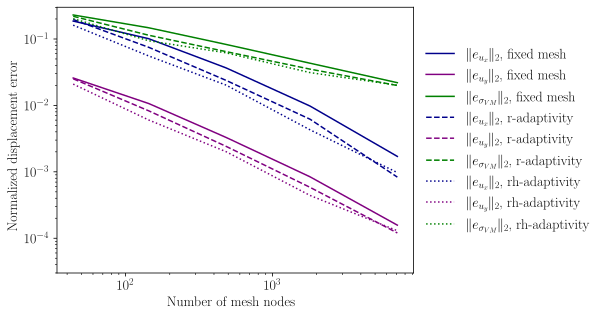

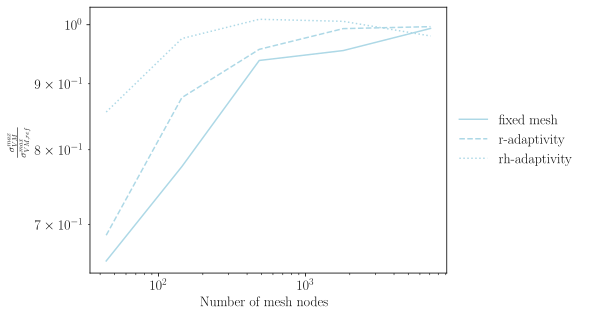

In [9]:
# Plot normalized displacement error
import matplotlib.pyplot as plt
import matplotlib

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

print(rh_adapt_error_u.shape)

plt.plot(mesh_resolution, error_u,'-', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", fixed mesh")
plt.plot(mesh_resolution, error_v,'-', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", fixed mesh")
plt.plot(mesh_resolution, error_stress,'-', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", fixed mesh")

plt.plot(mesh_resolution, r_adapt_error_u,'--', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", r-adaptivity")
plt.plot(mesh_resolution, r_adapt_error_v,'--', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", r-adaptivity")
plt.plot(mesh_resolution, r_adapt_error_stress,'--', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", r-adaptivity")

plt.plot(mesh_resolution, rh_adapt_error_u,':', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", rh-adaptivity")
plt.plot(mesh_resolution, rh_adapt_error_v,':', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", rh-adaptivity")
plt.plot(mesh_resolution, rh_adapt_error_stress,':', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", rh-adaptivity")


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.00003, 0.3])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()

# Plot maximal stress

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, error_stress_max,'-', color = "lightblue", label = "fixed mesh")
plt.plot(mesh_resolution, r_adapt_error_stress_max,'--', color = "lightblue", label =  "r-adaptivity")
plt.plot(mesh_resolution, rh_adapt_error_stress_max,':', color = "lightblue", label =  "rh-adaptivity")

ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel("Number of mesh nodes")
# plt.ylabel(r'$\sigma^{max}_{VM}$')
plt.ylabel(r'$\frac{\sigma_{VM}^{max}}{\sigma_{VM, ref}^{max}}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()
